### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

### Monocytes, Macrophages and DCs only

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240223

Yoshida PBMC dataset (subsetted to contain only healthy donors) and healthy human heart leucocytes (from Human cell atlas) were combined to generate a reference for seed labelling

### Import required modules

In [121]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [122]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
gmpy2               2.1.2
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.9.3
ml_collecti

In [123]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [124]:
torch.set_float32_matmul_precision('high')

In [125]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [126]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [127]:
#Merged Healthy reference = Yoshida_PBMC_data_from_healthy_human_donors + Human_Cell_Atlas_Cardiac_leucocytes_from_healthy_human_donors

reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merged_healthy_reference_PBMC_Heart_ac240222.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 214552 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

In [128]:
X_is_raw(reference)

True

In [129]:
reference.obs['seed_annotation_general'] = reference.obs['seed_labels'].copy()          #store general seed labels in new column to later fill in the specific seed labels in 'seed_labels'

In [130]:
reference.obs['seed_annotation_general'].cat.categories

Index(['B_cells', 'Baso_Eosino', 'CD4+T', 'CD8+T', 'DC', 'Doublets',
       'Hematopoetic', 'ILC', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK',
       'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'],
      dtype='object')

In [131]:
del(reference.obs['seed_labels'])
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()              #delete existing 'seed_labels' and create new 'seed_labels' with the specific cell states


In [132]:
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           32672
NK                                    22713
Classical monocyte                    20464
B naive                               19295
T CD8 naive                           16140
                                      ...  
T CD8 CTL IFN stim                       36
IL17RA+Mo                                32
AS-DC                                    28
Basophils & Eosinophils                  10
Hematopoietic progenitors IFN stim        2
Name: count, Length: 62, dtype: int64

In [133]:
reference.obs['seed_labels'].cat.categories

Index(['AS-DC', 'B invariant', 'B naive', 'B naive IFN stim',
       'B non-switched mem', 'B non-switched mem IFN stim', 'B switched mem',
       'B_cells', 'Basophils & Eosinophils', 'CD4+T_cytox', 'CD4+T_tem',
       'CD8+T_cytox', 'CD8+T_tem', 'CD14+Mo', 'CD16+Mo', 'Classical monocyte',
       'Classical monocyte IFN stim', 'Classical monocyte IL6+', 'Cycling',
       'DC', 'DOCK4+MØ1', 'DOCK4+MØ2', 'Hematopoietic progenitors',
       'Hematopoietic progenitors IFN stim', 'IL17RA+Mo', 'ILC', 'LYVE1+MØ1',
       'LYVE1+MØ2', 'LYVE1+MØ3', 'MAIT', 'Mast', 'Mo_pi', 'MØ_AgP', 'MØ_mod',
       'NK', 'NK CD56 bright', 'NK IFN stim', 'NKT', 'Non-classical monocyte',
       'Non-classical monocyte IFN stim', 'Non-classical monocyte complement+',
       'NØ', 'Plasma cells', 'Plasmablasts', 'Platelets', 'Red blood cells',
       'T CD4 CTL', 'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 central mem',
       'T CD8 effector mem', 'T CD

In [134]:
reference_momac_dc = reference[reference.obs["seed_annotation_general"].isin(["Macrophages", "Monocytes", "DC", "pDC"]), :]                 #Subset to keep only cell types of interest
reference_momac_dc

View of AnnData object with n_obs × n_vars = 52966 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels'
    var: 'name-Yoshida'

### Subset populations of interest

In [135]:
reference_momac_dc = reference_momac_dc[~reference_momac_dc.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells
reference_momac_dc.obs['seed_labels'].value_counts()

seed_labels
Classical monocyte                    20464
Non-classical monocyte                 4457
CD16+Mo                                3278
DOCK4+MØ1                              3239
LYVE1+MØ1                              3018
Classical monocyte IFN stim            2559
LYVE1+MØ2                              2088
LYVE1+MØ3                              1957
CD14+Mo                                1883
Mo_pi                                  1652
DOCK4+MØ2                              1626
cDC2                                   1371
MØ_mod                                 1313
MØ_AgP                                 1278
DC                                      814
pDC                                     706
Non-classical monocyte IFN stim         616
Non-classical monocyte complement+      464
Classical monocyte IL6+                  77
cDC1                                     46
IL17RA+Mo                                32
AS-DC                                    28
Name: count, dtype: 

In [136]:
sc.pp.filter_cells(reference_momac_dc, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference_momac_dc, min_counts = 100)

In [137]:
reference_momac_dc.obs

,COVID_status,annotation_broad,annotation_detailed,n_counts,n_genes,age_group,donor,sample,cell_source,cell_states,gender,NRP,region,scNym,scNym_confidence,seed_annotation_general,seed_labels
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-Yoshida,Healthy,Monocyte,Monocyte CD14,5493.0,1767,Adult,AN5,AN5,Yoshida,Classical monocyte,Female,NaN,NaN,NaN,NaN,Monocytes,Classical monocyte
CV001_KM10202384-CV001_KM10202394_AAACCTGGTTAAGTAG-1-Yoshida,Healthy,Monocyte,Monocyte CD14,4518.0,1657,Adult,AN5,AN5,Yoshida,Classical monocyte,Female,NaN,NaN,NaN,NaN,Monocytes,Classical monocyte
CV001_KM10202384-CV001_KM10202394_AAACCTGGTTAGATGA-1-Yoshida,Healthy,Monocyte,Monocyte CD14,6217.0,1994,Adult,AN5,AN5,Yoshida,Classical monocyte,Female,NaN,NaN,NaN,NaN,Monocytes,Classical monocyte
CV001_KM10202384-CV001_KM10202394_AAACCTGTCTTGCCGT-1-Yoshida,Healthy,Monocyte,Monocyte CD14,1978.0,1100,Adult,AN3,AN3,Yoshida,Classical monocyte,Male,NaN,NaN,NaN,NaN,Monocytes,Classical monocyte
CV001_KM10202384-CV001_KM10202394_AAAGATGAGGCCCGTT-1-Yoshida,Healthy,Monocyte,Monocyte CD16,7868.0,2335,Adult,AN5,AN5,Yoshida,Non-classical monocyte,Female,NaN,NaN,NaN,NaN,Monocytes,Non-classical monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCACCACTGG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,8208.0,2410,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ1,Female,Yes,AX,MØ,0.986432,Macrophages,LYVE1+MØ1
TTTGATCGTTCTCCTG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,8706.0,2526,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ1,Female,Yes,AX,CD8+T_cell,0.269561,Macrophages,LYVE1+MØ1
TTTGGAGGTCGCTCGA-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,3657.0,1350,NaN,D11,HCAHeart8102862,Sanger-CD45,MØ_AgP,Female,Yes,AX,M3,0.585436,Macrophages,MØ_AgP
TTTGGTTTCAGTGTTG-1-HCAHeart8102862-Sanger-CD45,NaN,NaN,NaN,9953.0,2505,NaN,D11,HCAHeart8102862,Sanger-CD45,LYVE1+MØ3,Female,Yes,AX,MØ,0.968681,Macrophages,LYVE1+MØ3


### Read in other query

In [138]:
#Now we read in the file of the already seed labeled Pkp2+Ttn Ctrls in order to be able to subset according to cell type of interest

query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 't

In [139]:
query.obs           # Make sure that 'seed_labels' is unknwon for query

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,8562.0,2769,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,50,18,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,49,18,Macrophages
AAACGCTTCTCGCTCA-1-A1-query,3855.0,1599,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,49,18,Monocytes
AAAGGTACAGAACATA-1-A1-query,17536.0,3854,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317631,-0.578954,query,50,18,Monocytes
AAAGTCCAGGGACACT-1-A1-query,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query,50,18,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query,54,18,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18,Macrophages


In [140]:
X_is_raw(query)

True

In [141]:
query_momac_dc = query[query.obs["C_scANVI"].isin(["Macrophages", "Monocytes", "DC", "pDC"]), :]            #Subset for cell type of interst
query_momac_dc

View of AnnData object with n_obs × n_vars = 6451 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts

In [142]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

In [143]:
del(query_momac_dc.obs["C_scANVI"])                                               #Delete C_scANVI as it will be newly assigned at the end of the notebook                    

In [144]:
query_momac_dc

View of AnnData object with n_obs × n_vars = 6451 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total

### Change gene symbols for label transfer

In [145]:
query_momac_dc.var_names = [gene_name.upper() for gene_name in query_momac_dc.var_names]                #capitalize gene names to match human nomenclature
query_momac_dc.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

### Merge reference data set and query data set

In [146]:
adata = reference_momac_dc.concatenate(query_momac_dc, batch_key = 'batch', batch_categories = ['reference_momac_dc', 'query_momac_dc'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 59417 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_momac_dc', 'feature_types-query_momac_dc', 'mt-query_momac_dc', 'ribo-query_momac_dc', 'n_cells_by_counts-A1-query_momac_dc', 'mean_counts-A1-query_momac_dc', 'pct_dropout_by_counts-A1-query_momac_dc', 'total_counts-A1-query_momac_dc', 'n_cells_by_counts-A2-query_momac_dc', 'mean_counts-A2-query_momac_dc', 'pct_dropout_by_counts-A2-query_momac_dc', 'total_counts-A2-query_momac_dc', 

In [147]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Classical monocyte                    20464
Unknown                                6451
Non-classical monocyte                 4457
CD16+Mo                                3278
DOCK4+MØ1                              3239
LYVE1+MØ1                              3018
Classical monocyte IFN stim            2559
LYVE1+MØ2                              2088
LYVE1+MØ3                              1957
CD14+Mo                                1883
Mo_pi                                  1652
DOCK4+MØ2                              1626
cDC2                                   1371
MØ_mod                                 1313
MØ_AgP                                 1278
DC                                      814
pDC                                     706
Non-classical monocyte IFN stim         616
Non-classical monocyte complement+      464
Classical monocyte IL6+                  77
cDC1                                     46
IL17RA+Mo                                32
AS-DC               

In [148]:
adata.obs['batch'].value_counts()

batch
reference_momac_dc    52966
query_momac_dc         6451
Name: count, dtype: int64

### Select HVGs

In [149]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D7                   4481
D6                   4385
D11                  3476
NP18                 3368
NP27                 2560
NP17                 1671
D3                   1620
NP19                 1600
AN12                 1586
Ttn_Ctr_noninf_1     1517
D2                   1424
NP36                 1392
AN13                 1361
NP21                 1340
Pkp2_Ctr_noninf_2    1308
Ttn_Ctr_noninf_2     1308
NP20                 1287
NP24                 1232
NP37                 1206
NP39                 1157
AN6                  1063
H7                   1038
Pkp2_Ctr_noninf_4    1017
NP28                  974
H3                    946
D4                    926
AN5                   909
D5                    885
AN7                   869
H2                    869
Pkp2_Ctr_noninf_3     773
AN9                   742
H4                    607
H5                    600
NP41                  587
AN2                   576
AN11                  576
H6                    555
NP22  

In [150]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,                     #only 2000 because we have only MoMacs + DCs
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 59417 × 3000
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-query_momac_dc', 'feature_types-query_momac_dc', 'mt-query_momac_dc', 'ribo-query_momac_dc', 'n_cells_by_counts-A1-query_momac_dc', 'mean_counts-A1-query_momac_dc', 'pct_dropout_by_counts-A1-query_momac_dc', 'total_counts-A1-query_momac_dc', 'n_cells_by_counts-A2-query_momac_dc', 'mean_counts-A2-query_momac_dc', 'pct_dropout_by_counts-A2-query_momac_dc', 'total_counts-A2-query_momac_dc', '

### Transfer of annotation with scANVI

In [151]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [152]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [153]:
scvi_model.train(80, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 80/80: 100%|██████████| 80/80 [03:02<00:00,  2.33s/it, v_num=1, train_loss_step=767, train_loss_epoch=801]  

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|██████████| 80/80 [03:02<00:00,  2.28s/it, v_num=1, train_loss_step=767, train_loss_epoch=801]


### Evaluate model performance a la _Sevensson_

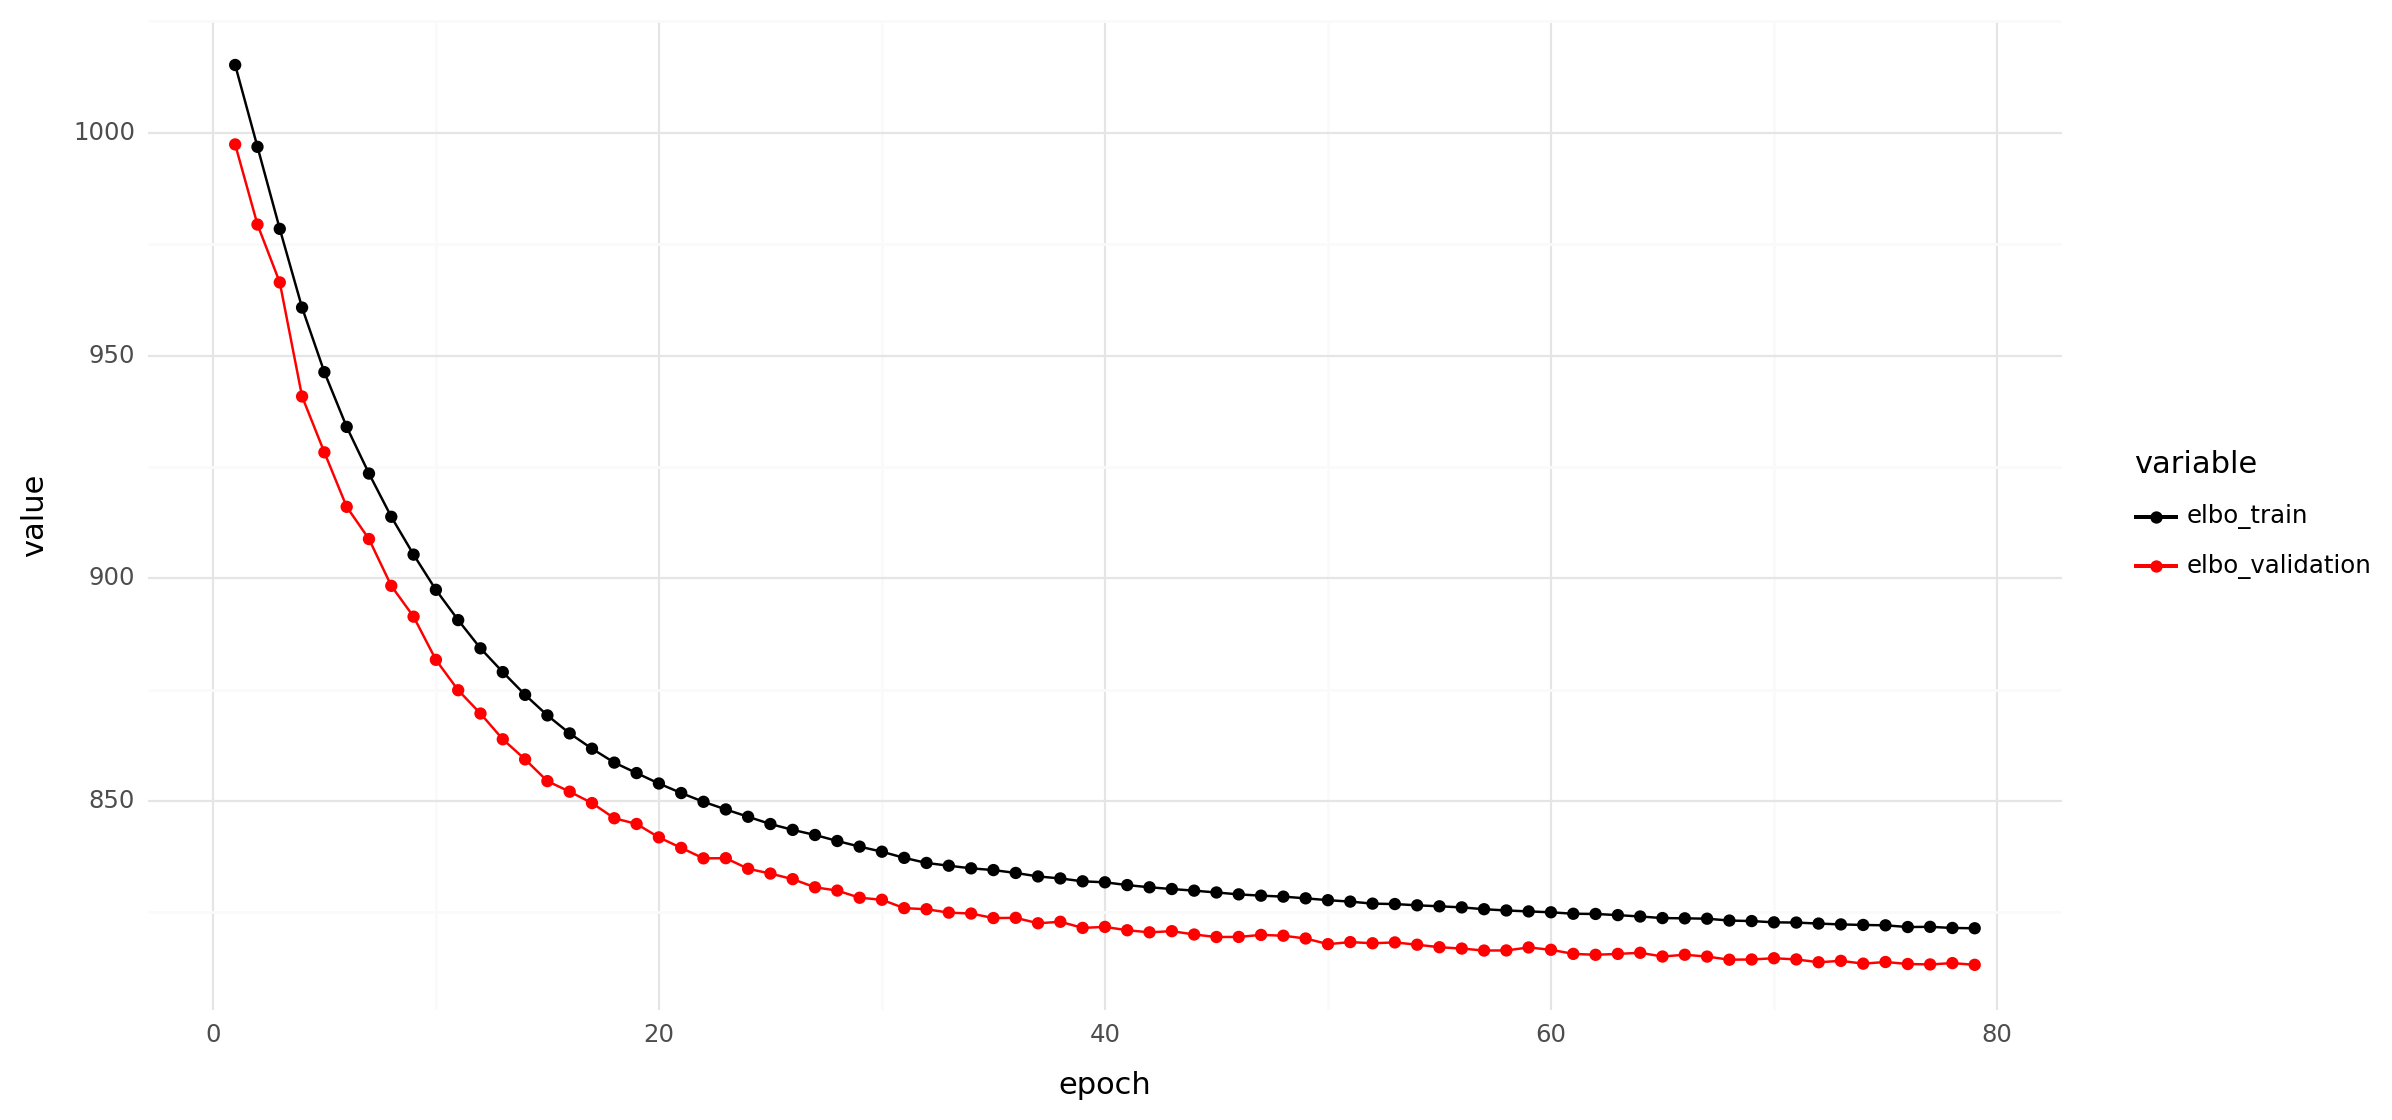

In [154]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [155]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [156]:
scanvi_model.train(80, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 80 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 80/80: 100%|██████████| 80/80 [09:06<00:00,  6.84s/it, v_num=1, train_loss_step=838, train_loss_epoch=804]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|██████████| 80/80 [09:06<00:00,  6.83s/it, v_num=1, train_loss_step=838, train_loss_epoch=804]


### Evaluate model performance a la Svensson

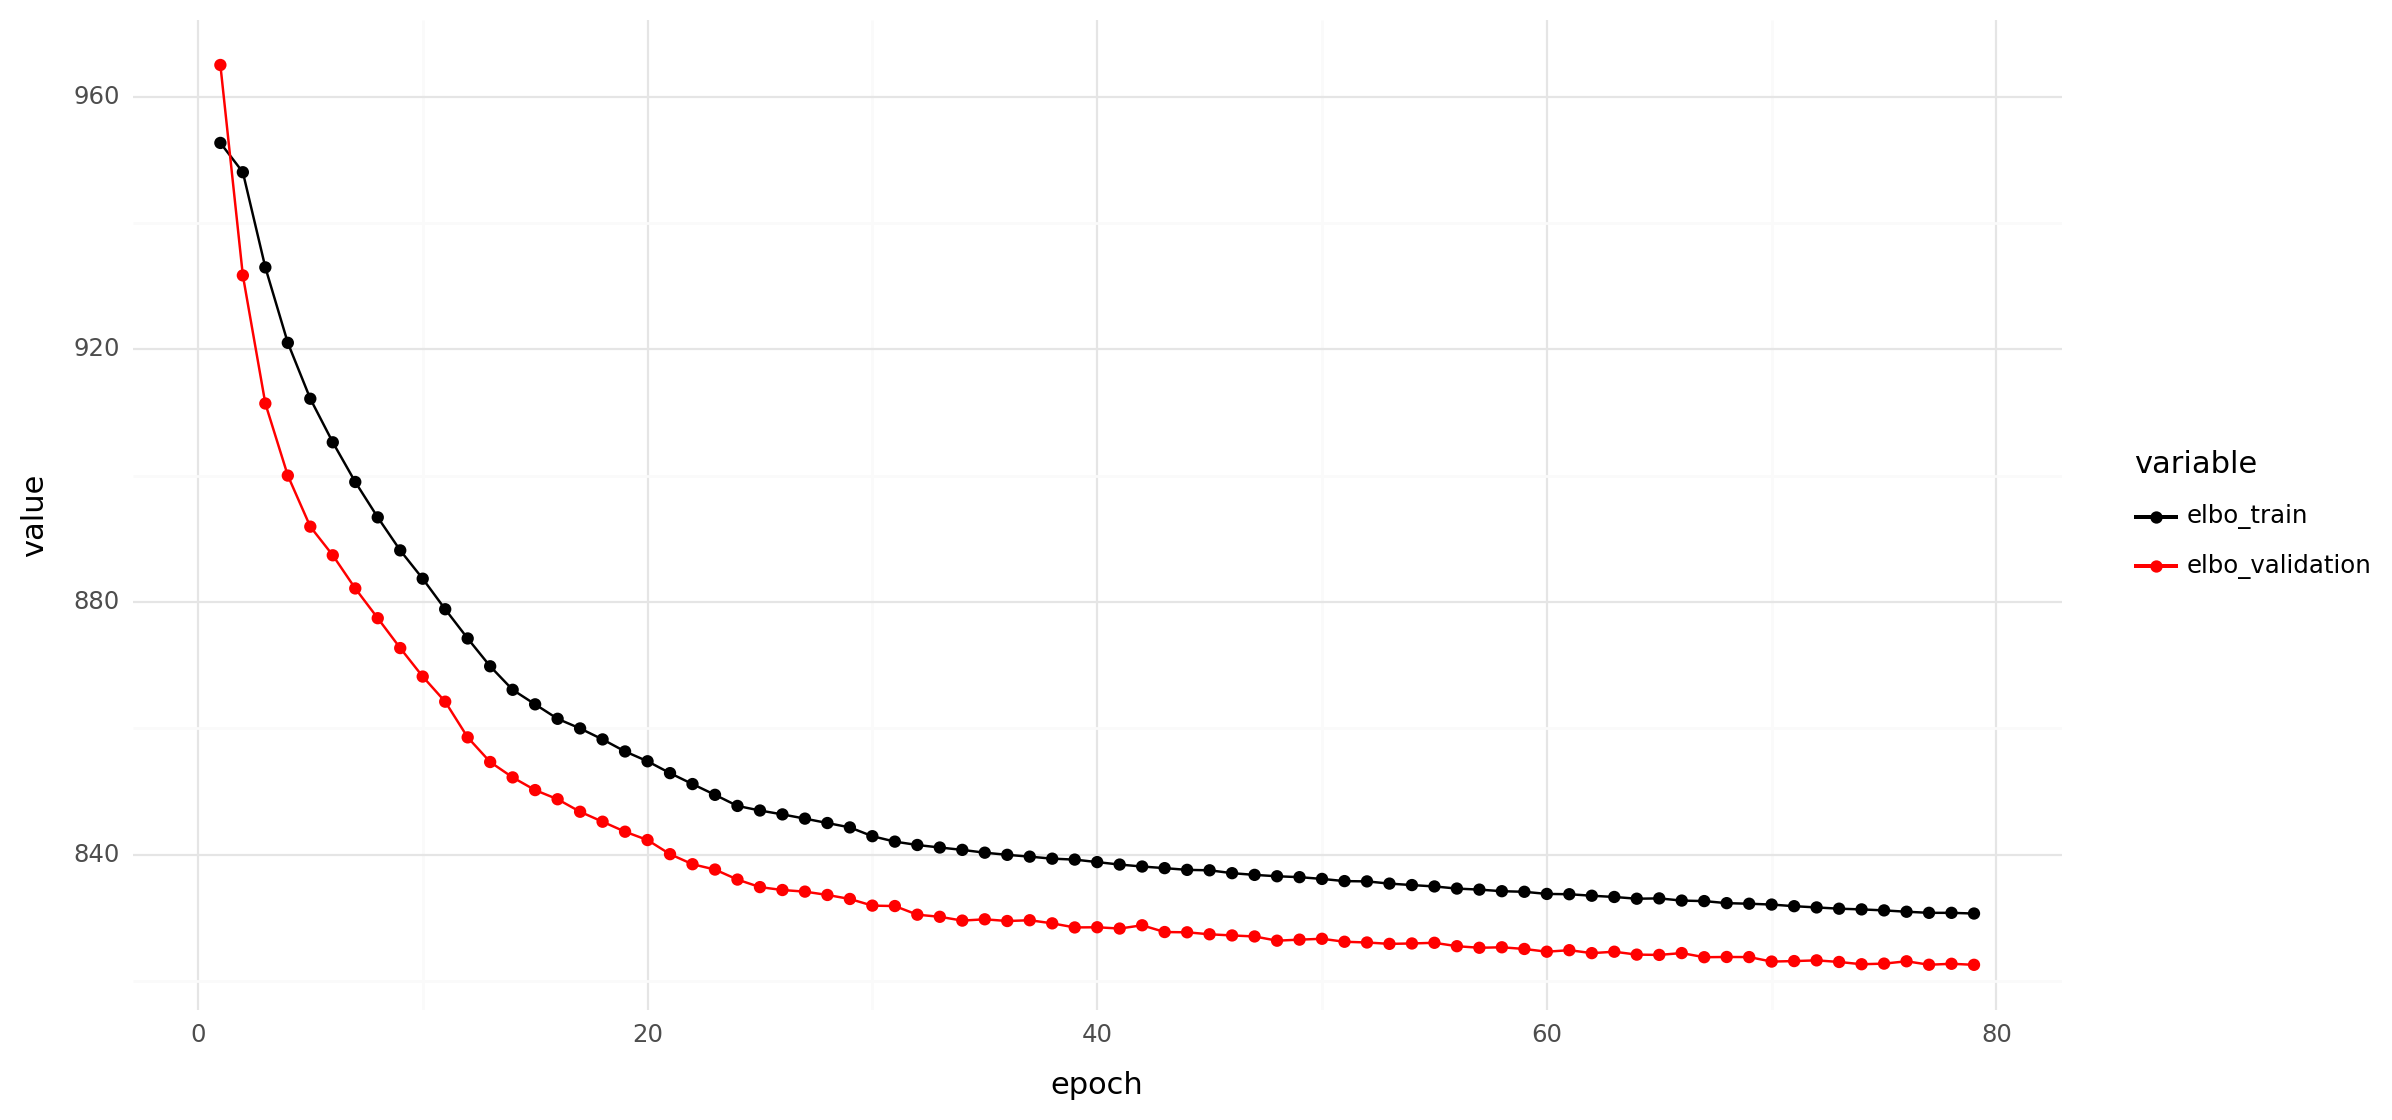

In [157]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [158]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [159]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [160]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


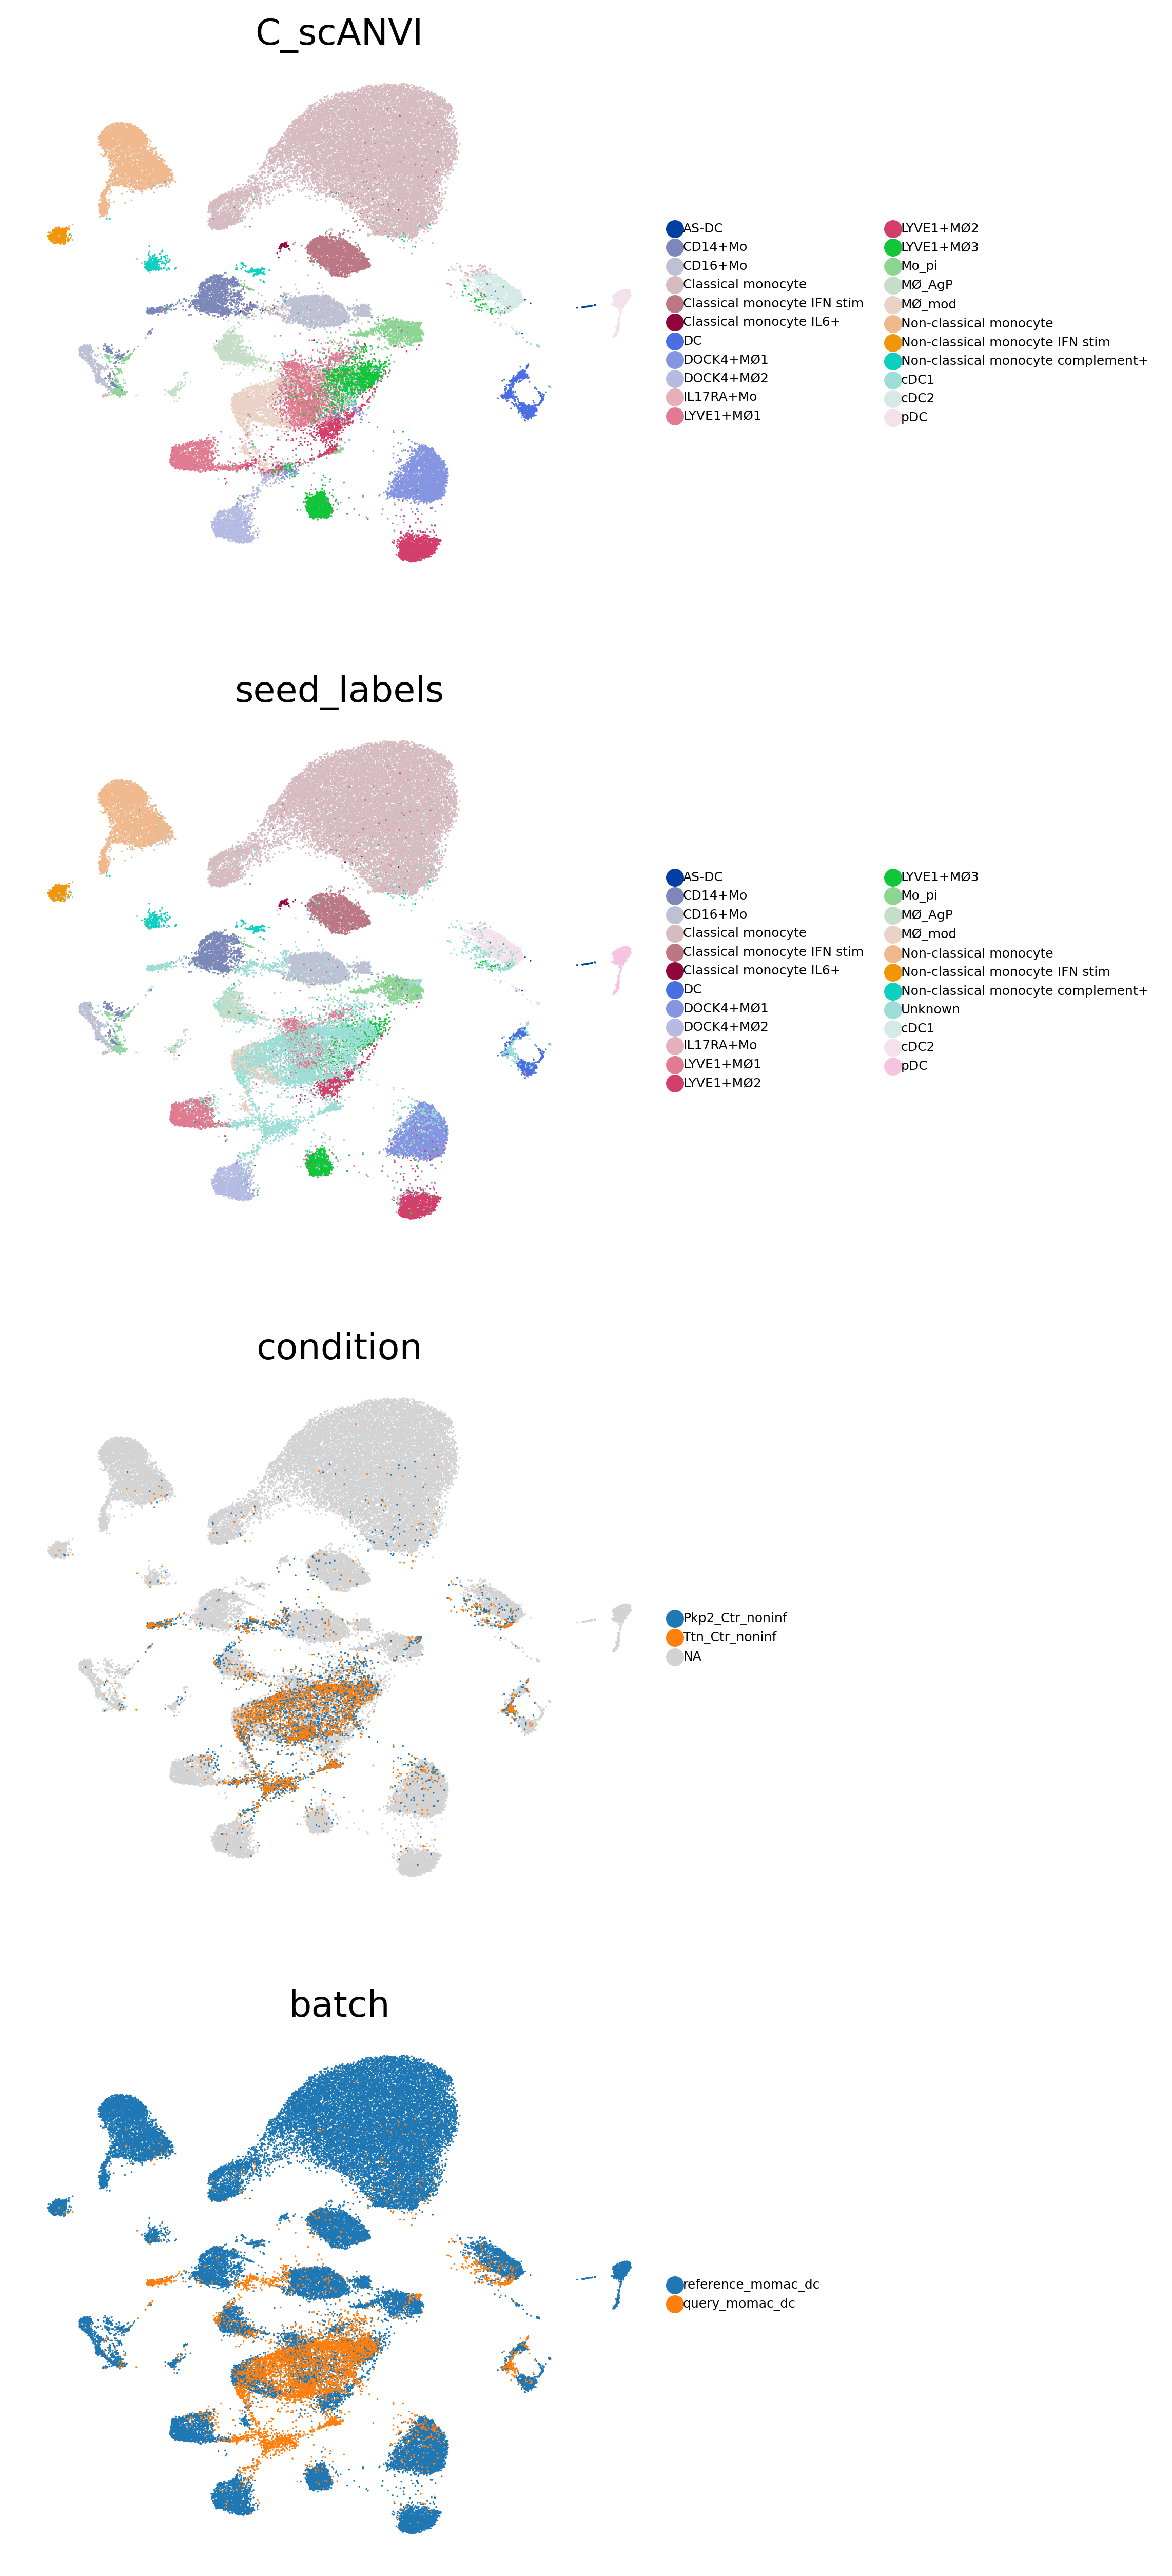

In [161]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch'], size = 2, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [162]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)                    #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

AnnData object with n_obs × n_vars = 59417 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_momac_dc', 'feature_types-query_momac_dc', 'mt-query_momac_dc', 'ribo-query_momac_dc', 'n_cells_by_counts-A1-query_momac_dc', 'mean_counts-A1-query_momac_dc', 'pct_dropout_by_counts-A1-query_momac_dc', 'total_counts-A1-query_momac_dc', 'n_cells_by_counts-A2-query_momac_dc', 'mean_counts-A2-query_momac_dc', 'pct_dropout_by_counts-A2-query_momac_dc', 'total_counts-A2-query

In [163]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query_momac_dc'])]                     #subset merged data set to keep only query
adata_export

View of AnnData object with n_obs × n_vars = 6451 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_momac_dc', 'feature_types-query_momac_dc', 'mt-query_momac_dc', 'ribo-query_momac_dc', 'n_cells_by_counts-A1-query_momac_dc', 'mean_counts-A1-query_momac_dc', 'pct_dropout_by_counts-A1-query_momac_dc', 'total_counts-A1-query_momac_dc', 'n_cells_by_counts-A2-query_momac_dc', 'mean_counts-A2-query_momac_dc', 'pct_dropout_by_counts-A2-query_momac_dc', 'total_counts-A

### Add new gene symbols

In [164]:
query_export = anndata.AnnData(X = query_momac_dc.X, var = query_momac_dc.var, obs = adata_export.obs)            #make sure to store the raw X values and the raw genes together with modified observations
query_export

AnnData object with n_obs × n_vars = 6451 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_cou

### Revert gene symbols

In [165]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]                     #restore mouse gene nomenclature
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [166]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
LYVE1+MØ1                             1408
MØ_mod                                1151
LYVE1+MØ3                              994
CD14+Mo                                419
MØ_AgP                                 390
LYVE1+MØ2                              362
DOCK4+MØ1                              283
DOCK4+MØ2                              238
Classical monocyte                     216
CD16+Mo                                203
cDC2                                   199
Mo_pi                                  196
DC                                     182
Non-classical monocyte complement+      85
Classical monocyte IFN stim             65
Non-classical monocyte                  38
Classical monocyte IL6+                 12
Non-classical monocyte IFN stim          5
AS-DC                                    2
cDC1                                     2
pDC                                      1
Name: count, dtype: int64

In [167]:
query_export

AnnData object with n_obs × n_vars = 6451 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_annotation_general', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_cou

In [168]:
X_is_raw(query_export)

True

In [169]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs["COVID_status"])
del(query_export.obs["annotation_broad"])
del(query_export.obs["annotation_detailed"])
del(query_export.obs['age_group'])
del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])
del(query_export.obs['seed_annotation_general'])

In [170]:
query_export.obs

,n_counts,n_genes,donor,sample,cell_source,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACGCTGTTGTGTTG-1-A1-query-query_momac_dc,750.0,365,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query_momac_dc,49,22,LYVE1+MØ2
AAACGCTTCTCGCTCA-1-A1-query-query_momac_dc,3855.0,1599,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query_momac_dc,49,22,LYVE1+MØ3
AAAGGTACAGAACATA-1-A1-query-query_momac_dc,17536.0,3854,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317631,-0.578954,query_momac_dc,50,22,CD14+Mo
AAAGTCCAGGGACACT-1-A1-query-query_momac_dc,14174.0,3788,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query_momac_dc,50,22,LYVE1+MØ1
AAAGTCCCAGTAGGAC-1-A1-query-query_momac_dc,12498.0,3493,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,9.809570,0.016323,0.040006,0.0,-0.142503,-0.357287,query_momac_dc,50,22,DOCK4+MØ1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query-query_momac_dc,18844.0,4219,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query_momac_dc,54,22,LYVE1+MØ1
TTTGGTTTCCTGTACC-1-B2-query-query_momac_dc,11805.0,3321,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query_momac_dc,54,22,MØ_mod
TTTGTTGCAAGCTCTA-1-B2-query-query_momac_dc,3733.0,1849,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query_momac_dc,53,22,DOCK4+MØ1
TTTGTTGTCCCAGGAC-1-B2-query-query_momac_dc,6388.0,2559,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query_momac_dc,54,22,MØ_mod


In [171]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/MoMacs+DCs_from_Ctrls_with_scANVI_cellstates_from_healthy_reference_ac240223.raw.h5ad')